# Visualização do Dataset original e criação do subdataset


## Etapas:
- Import da bibliotecas usadas.
- Load do Dataset original 2020 e 2024 junto com sorteio de um paciente exemplo.
- Plot de um slide de todas sequencias e as slices do paciente exemplo.
- Tabela indiocando o shape da imagens dos datasets.
- Tabela mostrando a quantidade de imagens (slices) totais e com tumor por sequencia e total de cada dataset.
- Seleção de 6 imagens (slices) de cada sequencia por paciente, selecionando apenas imagens com tumor trazendo representações de diferentes tamanhos por meio de quantis de tamanho da area do tumor.
- Conversão das imagens para .nyp e criação do subdataset salvo em uma pasta.
- Plot do mesmo paciente exemplo com o novo subdataset contendo apenas as 6 slices de cada sequencia.

In [1]:
import os, glob, random, csv, math
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from ipywidgets import interact
import pandas as pd

In [2]:
# ===== BraTS 2020 LOAD =====
base_path_20 = r"C:\Users\dados\Downloads\archive\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"

patient_dirs_20 = [
    os.path.join(base_path_20, d)
    for d in os.listdir(base_path_20)
    if os.path.isdir(os.path.join(base_path_20, d)) and d.startswith("BraTS20_Training_")
]
assert len(patient_dirs_20) > 0, "Nenhuma pasta BraTS20_Training_* encontrada."

patient_folder_20 = random.choice(patient_dirs_20)
print("Paciente (2020) escolhido:", os.path.basename(patient_folder_20))

def find_modal_paths_20(patient_folder):
    patt = lambda suf: glob.glob(os.path.join(patient_folder, f"*_{suf}.nii"))
    paths = {
        "t1":    (patt("t1")    or [None])[0],
        "t1ce":  (patt("t1ce")  or [None])[0],
        "t2":    (patt("t2")    or [None])[0],
        "flair": (patt("flair") or [None])[0],
        "seg":   (patt("seg")   or [None])[0],
    }
    miss = [k for k,v in paths.items() if v is None]
    if miss:
        raise FileNotFoundError(f"Arquivos ausentes em {patient_folder}: {miss}")
    return paths

paths20 = find_modal_paths_20(patient_folder_20)

# Carrega volumes (2020)
t1_20    = nib.load(paths20["t1"]).get_fdata()
t1c_20   = nib.load(paths20["t1ce"]).get_fdata()
t2_20    = nib.load(paths20["t2"]).get_fdata()
flair_20 = nib.load(paths20["flair"]).get_fdata()
seg_20   = nib.load(paths20["seg"]).get_fdata()

mask_bin_20 = (seg_20 > 0).astype(np.uint8)
Z20 = t1_20.shape[2]

Paciente (2020) escolhido: BraTS20_Training_123


In [3]:
# ===== BraTS 2020 plot =====
def viewer_20(z):
    # Cria a figura
    plt.figure(figsize=(20, 8))

    # ---------- LINHA DE CIMA (imagens + máscara original) ----------

    # (1) T1
    plt.subplot(2, 5, 1)
    plt.imshow(t1_20[:, :, z].T, cmap="gray", origin="lower")
    plt.title("T1")
    plt.axis("off")

    # (2) T1c
    plt.subplot(2, 5, 2)
    plt.imshow(t1c_20[:, :, z].T, cmap="gray", origin="lower")
    plt.title("T1c")
    plt.axis("off")

    # (3) T2w
    plt.subplot(2, 5, 3)
    plt.imshow(t2_20[:, :, z].T, cmap="gray", origin="lower")
    plt.title("T2w")
    plt.axis("off")

    # (4) FLAIR
    plt.subplot(2, 5, 4)
    plt.imshow(flair_20[:, :, z].T, cmap="gray", origin="lower")
    plt.title("FLAIR")
    plt.axis("off")

    # (5) Máscara ORIGINAL (multi-classes)
    plt.subplot(2, 5, 5)
    plt.imshow(seg_20[:, :, z].T, cmap="nipy_spectral", origin="lower")
    plt.title("Máscara (orig)")
    plt.axis("off")

    # ---------- LINHA DE BAIXO (overlays + máscara binária) ----------

    # Prepara a máscara binária da slice (H, W)
    m = (mask_bin_20[:, :, z].T > 0).astype(np.uint8)

    # (6) T1 + máscara
    plt.subplot(2, 5, 6)
    plt.imshow(t1_20[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("T1 + Másc")
    plt.axis("off")

    # (7) T1c + máscara
    plt.subplot(2, 5, 7)
    plt.imshow(t1c_20[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("T1c + Másc")
    plt.axis("off")

    # (8) T2w + máscara
    plt.subplot(2, 5, 8)
    plt.imshow(t2_20[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("T2w + Másc")
    plt.axis("off")

    # (9) FLAIR + máscara
    plt.subplot(2, 5, 9)
    plt.imshow(flair_20[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("FLAIR + Másc")
    plt.axis("off")

    # (10) Máscara BINÁRIA
    plt.subplot(2, 5, 10)
    plt.imshow(m, cmap="gray", origin="lower")
    plt.title("Máscara (bin)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

interact(viewer_20, z=(0, Z20-1))


interactive(children=(IntSlider(value=77, description='z', max=154), Output()), _dom_classes=('widget-interact…

<function __main__.viewer_20(z)>

In [4]:
# -------- BraTS 2020 SHAPE --------
assert all(n in globals() for n in ["t1_20","t1c_20","t2_20","flair_20","seg_20"])

rows_2020 = [
    {"dataset":"BraTS2020", "modalidade":"t1",    "H": t1_20.shape[0],   "W": t1_20.shape[1],   "Z": t1_20.shape[2]},
    {"dataset":"BraTS2020", "modalidade":"t1ce",  "H": t1c_20.shape[0],  "W": t1c_20.shape[1],  "Z": t1c_20.shape[2]},
    {"dataset":"BraTS2020", "modalidade":"t2",    "H": t2_20.shape[0],   "W": t2_20.shape[1],   "Z": t2_20.shape[2]},
    {"dataset":"BraTS2020", "modalidade":"flair", "H": flair_20.shape[0],"W": flair_20.shape[1],"Z": flair_20.shape[2]},
    {"dataset":"BraTS2020", "modalidade":"seg",   "H": seg_20.shape[0],  "W": seg_20.shape[1],  "Z": seg_20.shape[2]},
]
df_2020 = pd.DataFrame(rows_2020).sort_values("modalidade").reset_index(drop=True)
df_2020

,dataset,modalidade,H,W,Z
0,BraTS2020,flair,240,240,155
1,BraTS2020,seg,240,240,155
2,BraTS2020,t1,240,240,155
3,BraTS2020,t1ce,240,240,155
4,BraTS2020,t2,240,240,155


In [5]:
assert 'base_path_20' in globals(), "Defina base_path_20 antes desta célula."

# ---------- Config (2020) ----------
_modalidades_20 = ["t1", "t1ce", "t2", "flair", "seg"]

# ---------- Helpers (2020) ----------
def _list_patient_dirs_20(base, prefix="BraTS20_Training_"):
    return [
        os.path.join(base, d)
        for d in os.listdir(base)
        if os.path.isdir(os.path.join(base, d)) and d.startswith(prefix)
    ]

def _find_modal_paths_20(patient_folder):
    hits = {m: None for m in _modalidades_20}
    for root, _, files in os.walk(patient_folder):
        for f in files:
            fl = f.lower()
            if not (fl.endswith(".nii") or fl.endswith(".nii.gz")):
                continue
            p = os.path.join(root, f)
            if "_t1ce" in fl:
                hits["t1ce"] = hits["t1ce"] or p
            elif "_t1" in fl and "t1ce" not in fl:
                hits["t1"] = hits["t1"] or p
            elif "_t2" in fl and "flair" not in fl:
                hits["t2"] = hits["t2"] or p
            elif "_flair" in fl:
                hits["flair"] = hits["flair"] or p
            elif "_seg" in fl or "-seg" in fl or fl.startswith("seg") or "label" in fl or "mask" in fl:
                hits["seg"] = hits["seg"] or p
    return hits

def _z_from_header(path):
    if path is None:
        return np.nan
    return nib.load(path).shape[2]

# ---------- Varredura (2020) ----------
patient_dirs_20 = _list_patient_dirs_20(base_path_20)
assert len(patient_dirs_20) > 0, "Nenhuma pasta BraTS20_Training_* encontrada."

# Acumuladores por sequência
slices_total_by_seq_20 = {m: 0 for m in _modalidades_20}
tumor_slices_by_seq_20 = {m: 0 for m in _modalidades_20}

n_patients_20 = 0

for pf in patient_dirs_20:
    paths = _find_modal_paths_20(pf)
    # paciente conta se tiver ao menos 1 modalidade
    if not any(paths[m] is not None for m in _modalidades_20):
        continue
    n_patients_20 += 1

    # Carrega seg uma única vez (se existir) e vetoriza tumor por fatia
    seg_path = paths["seg"]
    seg_vec = None
    z_seg = 0
    if seg_path is not None:
        seg_vol = nib.load(seg_path).get_fdata()
        z_seg = seg_vol.shape[2]
        seg_vec = np.array([(seg_vol[:, :, z] > 0).any() for z in range(z_seg)], dtype=bool)

    # Para cada sequência, soma Z e tumor slices (limitado por min(Z_seq, Z_seg))
    for m in _modalidades_20:
        p = paths[m]
        if p is None:
            continue
        z_seq = _z_from_header(p)
        if not np.isnan(z_seq):
            slices_total_by_seq_20[m] += int(z_seq)
            if (m != "seg") and (seg_vec is not None):
                # conta quantas fatias do seg têm tumor dentro do intervalo disponível na sequência
                z_use = min(int(z_seq), int(z_seg))
                tumor_slices_by_seq_20[m] += int(seg_vec[:z_use].sum())
            elif m == "seg" and seg_vec is not None:
                tumor_slices_by_seq_20[m] += int(seg_vec.sum())

# ---------- DataFrame (2020) ----------
rows_20 = []
for m in _modalidades_20:
    rows_20.append({
        "dataset": "BraTS2020",
        "sequencia": m,
        "slices_total_seq": slices_total_by_seq_20[m],
        "slices_com_tumor_seq": tumor_slices_by_seq_20[m],
    })

df_2020_summary = pd.DataFrame(rows_20)

df_2020_total = pd.DataFrame([{
    "dataset": "BraTS2020",
    "sequencia": "TODAS",
    "slices_totais_dataset": int(df_2020_summary["slices_total_seq"].sum()),
    "slices_totais_com_tumor": int(df_2020_summary["slices_com_tumor_seq"].sum()),
    "pacientes": n_patients_20
}])

df_2020_summary

,dataset,sequencia,slices_total_seq,slices_com_tumor_seq
0,BraTS2020,t1,54250,23165
1,BraTS2020,t1ce,54250,23165
2,BraTS2020,t2,54250,23165
3,BraTS2020,flair,54250,23165
4,BraTS2020,seg,54250,23165


In [6]:
df_2020_total

,dataset,sequencia,slices_totais_dataset,slices_totais_com_tumor,pacientes
0,BraTS2020,TODAS,271250,115825,350


In [7]:
# ===== BraTS 2024 LOAD =====
base_path_24 = r"C:\Users\dados\Downloads\BraTS2024-BraTS-GLI-TrainingData\training_data1_v2"

patient_dirs_24 = [
    os.path.join(base_path_24, d)
    for d in os.listdir(base_path_24)
    if os.path.isdir(os.path.join(base_path_24, d)) and d.startswith("BraTS-GLI-")
]
assert len(patient_dirs_24) > 0, "Nenhuma pasta BraTS-GLI-* encontrada."

patient_folder_24 = random.choice(patient_dirs_24)
print("Paciente (2024) escolhido:", os.path.basename(patient_folder_24))

def find_modal_paths_24(patient_folder):
    def patt(suf):
        patterns = [
            os.path.join(patient_folder, f"*_{suf}.nii"),
            os.path.join(patient_folder, f"*_{suf}.nii.gz"),
            os.path.join(patient_folder, f"*-{suf}.nii"),
            os.path.join(patient_folder, f"*-{suf}.nii.gz"),
            os.path.join(patient_folder, f"*{suf}.nii"),
            os.path.join(patient_folder, f"*{suf}.nii.gz"),
        ]
        hits = []
        for p in patterns:
            hits.extend(glob.glob(p))
        return hits
    paths = {
        "t1n": (patt("t1n") or patt("t1native") or [None])[0],
        "t1c": (patt("t1c") or patt("t1ce") or patt("t1gd") or [None])[0],
        "t2w": (patt("t2w") or patt("t2") or [None])[0],
        "t2f": (patt("t2f") or patt("flair") or [None])[0],  # FLAIR equivalente
        "seg": (patt("seg") or patt("label") or patt("mask") or [None])[0],
    }
    miss = [k for k,v in paths.items() if v is None]
    if miss:
        raise FileNotFoundError(f"Arquivos ausentes em {patient_folder}: {miss}")
    return paths

paths24 = find_modal_paths_24(patient_folder_24)

# Carrega volumes (2024)
t1n_24 = nib.load(paths24["t1n"]).get_fdata()
t1c_24 = nib.load(paths24["t1c"]).get_fdata()
t2w_24 = nib.load(paths24["t2w"]).get_fdata()
t2f_24 = nib.load(paths24["t2f"]).get_fdata()   # FLAIR no 2024
seg_24  = nib.load(paths24["seg"]).get_fdata()

mask_bin_24 = (seg_24 > 0).astype(np.uint8)
Z24 = t1n_24.shape[2]

Paciente (2024) escolhido: BraTS-GLI-02149-103


In [8]:
# ===== BraTS 2024 plot =====
def viewer_24(z):
    # Cria a figura
    plt.figure(figsize=(20, 8))

    # ---------- LINHA DE CIMA (imagens brutas + máscara original) ----------

    # (1) T1n
    plt.subplot(2, 5, 1)
    plt.imshow(t1n_24[:, :, z].T, cmap="gray", origin="lower")
    plt.title("T1n")
    plt.axis("off")

    # (2) T1c
    plt.subplot(2, 5, 2)
    plt.imshow(t1c_24[:, :, z].T, cmap="gray", origin="lower")
    plt.title("T1c")
    plt.axis("off")

    # (3) T2w
    plt.subplot(2, 5, 3)
    plt.imshow(t2w_24[:, :, z].T, cmap="gray", origin="lower")
    plt.title("T2w")
    plt.axis("off")

    # (4) T2f / FLAIR
    plt.subplot(2, 5, 4)
    plt.imshow(t2f_24[:, :, z].T, cmap="gray", origin="lower")
    plt.title("T2f / FLAIR")
    plt.axis("off")

    # (5) Máscara ORIGINAL (pode ter múltiplas classes)
    plt.subplot(2, 5, 5)
    plt.imshow(seg_24[:, :, z].T, cmap="nipy_spectral", origin="lower")
    plt.title("Máscara (orig)")
    plt.axis("off")

    # ---------- LINHA DE BAIXO (overlays + máscara binária) ----------

    # Prepara a máscara binária da slice (H, W)
    m = (mask_bin_24[:, :, z].T > 0).astype(np.uint8)

    # (6) T1n + máscara
    plt.subplot(2, 5, 6)
    plt.imshow(t1n_24[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("T1n + Másc")
    plt.axis("off")

    # (7) T1c + máscara
    plt.subplot(2, 5, 7)
    plt.imshow(t1c_24[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("T1c + Másc")
    plt.axis("off")

    # (8) T2w + máscara
    plt.subplot(2, 5, 8)
    plt.imshow(t2w_24[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("T2w + Másc")
    plt.axis("off")

    # (9) T2f / FLAIR + máscara
    plt.subplot(2, 5, 9)
    plt.imshow(t2f_24[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("T2f + Másc")
    plt.axis("off")

    # (10) Máscara BINÁRIA
    plt.subplot(2, 5, 10)
    plt.imshow(m, cmap="gray", origin="lower")
    plt.title("Máscara (bin)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

interact(viewer_24, z=(0, Z24-1))

interactive(children=(IntSlider(value=90, description='z', max=181), Output()), _dom_classes=('widget-interact…

<function __main__.viewer_24(z)>

In [9]:
# -------- BraTS 2024 SHAPE --------
assert all(n in globals() for n in ["t1n_24","t1c_24","t2w_24","t2f_24","seg_24"])

rows_2024 = [
    {"dataset":"BraTS2024", "modalidade":"t1n", "H": t1n_24.shape[0], "W": t1n_24.shape[1], "Z": t1n_24.shape[2]},
    {"dataset":"BraTS2024", "modalidade":"t1c", "H": t1c_24.shape[0], "W": t1c_24.shape[1], "Z": t1c_24.shape[2]},
    {"dataset":"BraTS2024", "modalidade":"t2w", "H": t2w_24.shape[0], "W": t2w_24.shape[1], "Z": t2w_24.shape[2]},
    {"dataset":"BraTS2024", "modalidade":"t2f", "H": t2f_24.shape[0], "W": t2f_24.shape[1], "Z": t2f_24.shape[2]},
    {"dataset":"BraTS2024", "modalidade":"seg", "H": seg_24.shape[0],  "W": seg_24.shape[1],  "Z": seg_24.shape[2]},
]
df_2024 = pd.DataFrame(rows_2024).sort_values("modalidade").reset_index(drop=True)
df_2024

,dataset,modalidade,H,W,Z
0,BraTS2024,seg,182,218,182
1,BraTS2024,t1c,182,218,182
2,BraTS2024,t1n,182,218,182
3,BraTS2024,t2f,182,218,182
4,BraTS2024,t2w,182,218,182


In [10]:
assert 'base_path_24' in globals(), "Defina base_path_24 antes desta célula."

# ---------- Config (2024) ----------
_modalidades_24 = ["t1n", "t1c", "t2w", "t2f", "seg"]

# ---------- Helpers (2024) ----------
def _list_patient_dirs_24(base, prefix="BraTS-GLI-"):
    return [
        os.path.join(base, d)
        for d in os.listdir(base)
        if os.path.isdir(os.path.join(base, d)) and d.startswith(prefix)
    ]

def _find_modal_paths_24(patient_folder):
    hits = {m: None for m in _modalidades_24}
    for root, _, files in os.walk(patient_folder):
        for f in files:
            fl = f.lower()
            if not (fl.endswith(".nii") or fl.endswith(".nii.gz")):
                continue
            p = os.path.join(root, f)
            if ("t1n" in fl) or ("t1native" in fl):
                hits["t1n"] = hits["t1n"] or p
            elif ("t1c" in fl) or ("t1ce" in fl) or ("t1gd" in fl):
                hits["t1c"] = hits["t1c"] or p
            elif ("t2w" in fl) or (("t2" in fl) and ("flair" not in fl) and ("t2f" not in fl)):
                hits["t2w"] = hits["t2w"] or p
            elif ("t2f" in fl) or ("flair" in fl):
                hits["t2f"] = hits["t2f"] or p
            elif ("_seg" in fl) or (fl.startswith("seg")) or ("-seg" in fl) or ("label" in fl) or ("mask" in fl):
                hits["seg"] = hits["seg"] or p
    return hits

def _z_from_header(path):
    if path is None:
        return np.nan
    return nib.load(path).shape[2]

# ---------- Varredura (2024) ----------
patient_dirs_24 = _list_patient_dirs_24(base_path_24)
assert len(patient_dirs_24) > 0, "Nenhuma pasta BraTS-GLI-* encontrada."

slices_total_by_seq_24 = {m: 0 for m in _modalidades_24}
tumor_slices_by_seq_24 = {m: 0 for m in _modalidades_24}

n_patients_24 = 0

for pf in patient_dirs_24:
    paths = _find_modal_paths_24(pf)
    if not any(paths[m] is not None for m in _modalidades_24):
        continue
    n_patients_24 += 1

    seg_path = paths["seg"]
    seg_vec = None
    z_seg = 0
    if seg_path is not None:
        seg_vol = nib.load(seg_path).get_fdata()
        z_seg = seg_vol.shape[2]
        seg_vec = np.array([(seg_vol[:, :, z] > 0).any() for z in range(z_seg)], dtype=bool)

    for m in _modalidades_24:
        p = paths[m]
        if p is None:
            continue
        z_seq = _z_from_header(p)
        if not np.isnan(z_seq):
            slices_total_by_seq_24[m] += int(z_seq)
            if (m != "seg") and (seg_vec is not None):
                z_use = min(int(z_seq), int(z_seg))
                tumor_slices_by_seq_24[m] += int(seg_vec[:z_use].sum())
            elif m == "seg" and seg_vec is not None:
                tumor_slices_by_seq_24[m] += int(seg_vec.sum())

# ---------- DataFrame (2024) ----------
rows_24 = []
for m in _modalidades_24:
    rows_24.append({
        "dataset": "BraTS2024",
        "sequencia": m,
        "slices_total_seq": slices_total_by_seq_24[m],
        "slices_com_tumor_seq": tumor_slices_by_seq_24[m],
    })

df_2024_summary = pd.DataFrame(rows_24)

df_2024_total = pd.DataFrame([{
    "dataset": "BraTS2024",
    "sequencia": "TODAS",
    "slices_totais_dataset": int(df_2024_summary["slices_total_seq"].sum()),
    "slices_totais_com_tumor": int(df_2024_summary["slices_com_tumor_seq"].sum()),
    "pacientes": n_patients_24
}])

df_2024_summary

,dataset,sequencia,slices_total_seq,slices_com_tumor_seq
0,BraTS2024,t1n,245700,90807
1,BraTS2024,t1c,245700,90807
2,BraTS2024,t2w,245700,90807
3,BraTS2024,t2f,245700,90807
4,BraTS2024,seg,245700,90807


In [11]:
df_2024_total

,dataset,sequencia,slices_totais_dataset,slices_totais_com_tumor,pacientes
0,BraTS2024,TODAS,1228500,454035,1350


In [12]:
SUBDATASET_2020  = r"C:\Users\dados\Documents\mini_datasets\mini_npy_2020"
DTYPE_SAVE_IMG   = np.float32  # use np.float16 para reduzir tamanho
DTYPE_SAVE_MASK  = np.uint8
QUANTIS          = [0.05, 0.22, 0.39, 0.61, 0.78, 0.95]
SEQ_KEYS_2020    = ["flair","t1","t1ce","t2","seg"]

os.makedirs(SUBDATASET_2020, exist_ok=True)

# ---------- MAPA DE ARQUIVOS ----------
def find_modal_paths_20(patient_folder):
    patt = lambda suf: glob.glob(os.path.join(patient_folder, f"*_{suf}.nii"))
    paths = {
        "t1":    (patt("t1")    or [None])[0],
        "t1ce":  (patt("t1ce")  or [None])[0],
        "t2":    (patt("t2")    or [None])[0],
        "flair": (patt("flair") or [None])[0],
        "seg":   (patt("seg")   or [None])[0],
    }
    miss = [k for k,v in paths.items() if v is None]
    if miss: raise FileNotFoundError(f"Ausentes em {patient_folder}: {miss}")
    return paths

patient_dirs_20 = [
    os.path.join(base_path_20, d)
    for d in os.listdir(base_path_20)
    if os.path.isdir(os.path.join(base_path_20, d)) and d.startswith("BraTS20_Training_")
]
assert len(patient_dirs_20) > 0, "Nenhum paciente BraTS20_Training_* encontrado."

# ---------- SELEÇÃO (quantis por área) ----------
def select_six_by_area_from_mask(seg_bin):
    areas = seg_bin.sum(axis=(0,1))
    z_idx = np.where(areas > 0)[0]
    if len(z_idx) == 0:
        return [], areas
    order = z_idx[np.argsort(areas[z_idx])]
    if len(order) >= 6:
        picks = [order[int(round((len(order)-1)*q))] for q in QUANTIS]
        uniq  = list(dict.fromkeys(int(i) for i in picks))
        if len(uniq) < 6:
            remaining = [int(z) for z in order if z not in uniq][::-1]
            for z in remaining:
                uniq.append(z); 
                if len(uniq) == 6: break
        sel = sorted(uniq)
    else:
        base = order.tolist()
        i = 0
        while len(base) < 6:
            base.append(order[i % len(order)]); i += 1
        sel = sorted(int(z) for z in base[:6])
    return sel, areas

# ---------- LOOP PRINCIPAL ----------
rows = []
slice_count = 0

for idx, pdir in enumerate(sorted(patient_dirs_20), 1):
    pid = os.path.basename(pdir)
    try:
        paths = find_modal_paths_20(pdir)

        # carrega volumes uma vez
        t1    = nib.load(paths["t1"]).get_fdata(dtype=np.float32)
        t1ce  = nib.load(paths["t1ce"]).get_fdata(dtype=np.float32)
        t2    = nib.load(paths["t2"]).get_fdata(dtype=np.float32)
        flair = nib.load(paths["flair"]).get_fdata(dtype=np.float32)
        seg   = nib.load(paths["seg"]).get_fdata()
        seg_b = (seg > 0).astype(DTYPE_SAVE_MASK)

        sel_z, areas = select_six_by_area_from_mask(seg_b)
        if len(sel_z) == 0:
            continue

        out_dir = os.path.join(SUBDATASET_2020, pid)
        os.makedirs(out_dir, exist_ok=True)

        H, W, Z = flair.shape
        for k, z in enumerate(sel_z):
            files = {}
            for key, vol in (("flair",flair),("t1",t1),("t1ce",t1ce),("t2",t2)):
                arr = vol[:, :, z].astype(DTYPE_SAVE_IMG, copy=False)
                fname = f"{key}_z{z:03d}_{k:02d}.npy"
                np.save(os.path.join(out_dir, fname), arr)
                files[key] = os.path.join(pid, fname)
            # máscara
            m = seg_b[:, :, z]
            fname_m = f"seg_z{z:03d}_{k:02d}.npy"
            np.save(os.path.join(out_dir, fname_m), m)
            files["seg"] = os.path.join(pid, fname_m)

            rows.append({
                "ano": 2020,
                "paciente": pid,
                "z": int(z),
                "idx_local": k,
                "area_tumor_px": int(areas[z]),
                "H": int(H), "W": int(W),
                **{fpath: files[fpath] for fpath in SEQ_KEYS_2020}
            })

            slice_count += 1
            if slice_count % 120 == 0:
                print(f"[2020] {slice_count} slices processados...")

    except Exception as e:
        print(f"[ERRO 2020] {pid}: {e}")

# ---------- METADATA ----------
meta2020 = pd.DataFrame(rows, columns=[
    "ano","paciente","z","idx_local","area_tumor_px","H","W",*SEQ_KEYS_2020
])
csv_path = os.path.join(SUBDATASET_2020, "metadata_2020.csv")
meta2020.to_csv(csv_path, index=False, quoting=csv.QUOTE_MINIMAL)

print(f"[OK 2020] Salvo: {csv_path}")
print(f"[2020] Total pacientes: {meta2020['paciente'].nunique()} | total slices: {len(meta2020)}")

[2020] 120 slices processados...
[2020] 240 slices processados...
[2020] 360 slices processados...
[2020] 480 slices processados...
[2020] 600 slices processados...
[2020] 720 slices processados...
[2020] 840 slices processados...
[2020] 960 slices processados...
[2020] 1080 slices processados...
[2020] 1200 slices processados...
[2020] 1320 slices processados...
[2020] 1440 slices processados...
[2020] 1560 slices processados...
[2020] 1680 slices processados...
[2020] 1800 slices processados...
[2020] 1920 slices processados...
[2020] 2040 slices processados...
[OK 2020] Salvo: C:\Users\dados\Documents\mini_datasets\mini_npy_2020\metadata_2020.csv
[2020] Total pacientes: 350 | total slices: 2100


,ano,flair,t1,t1ce,t2,seg,total_imagens
0,2020,2100,2100,2100,2100,2100,10500


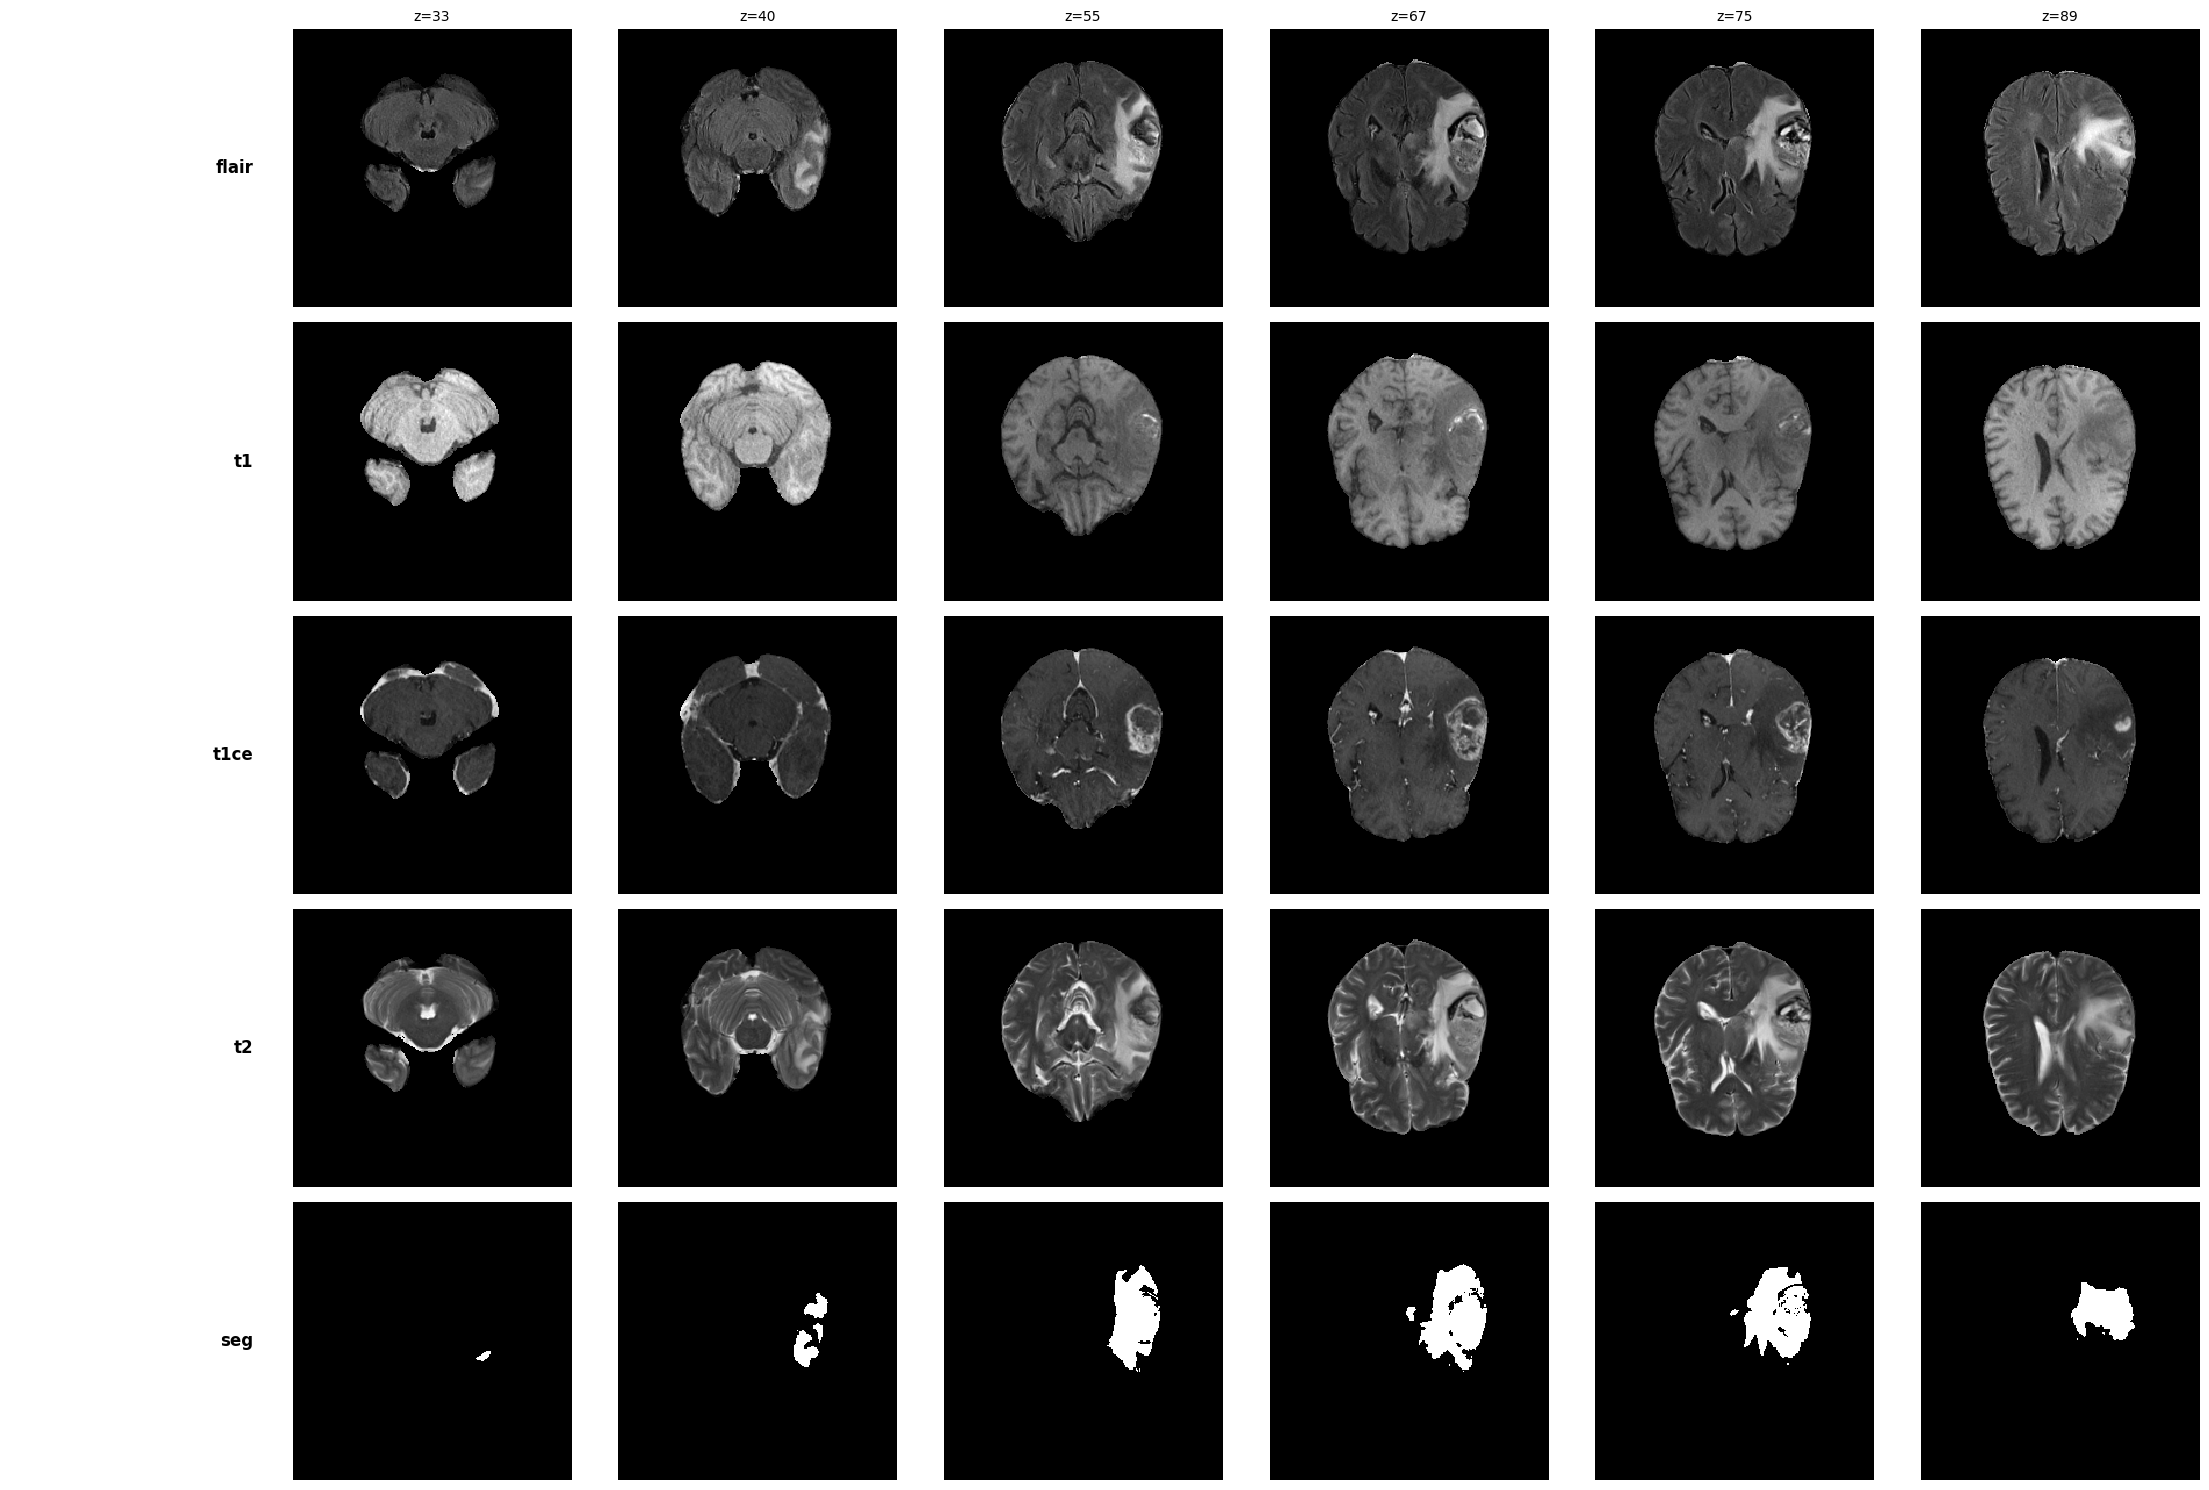

In [13]:
META_2020_CSV   = os.path.join(SUBDATASET_2020, "metadata_2020.csv")
SEQ_2020        = ["flair","t1","t1ce","t2","seg"]

# 1) Carrega metadata e faz contagem por sequência + total
meta2020 = pd.read_csv(META_2020_CSV)
counts_2020 = {seq: int(meta2020[seq].notna().sum()) for seq in SEQ_2020}
counts_2020["total_imagens"] = sum(counts_2020[s] for s in SEQ_2020)
df_count_2020 = pd.DataFrame([{ "ano": 2020, **counts_2020 }])
display(df_count_2020)

# 2) Seleciona paciente já escolhido no DataLoader (fallback para primeiro do CSV)
pid20 = os.path.basename(patient_folder_20) if "patient_folder_20" in globals() else meta2020["paciente"].iloc[0]
rows20 = meta2020.loc[meta2020["paciente"] == pid20].sort_values(["idx_local","z"]).reset_index(drop=True)
assert len(rows20) > 0, f"Nenhuma linha no metadata para paciente {pid20}"

# 3) Carrega slices (.npy)
def load_npy_2020(rel_path):
    return np.load(os.path.join(SUBDATASET_2020, rel_path))

seq2slices_20 = {k: [] for k in SEQ_2020}
sel_z_20 = []
for _, r in rows20.iterrows():
    for seq in SEQ_2020:
        seq2slices_20[seq].append(load_npy_2020(r[seq]))
    sel_z_20.append(int(r["z"]))

# garante no máximo 6 colunas
for k in SEQ_2020:
    seq2slices_20[k] = seq2slices_20[k][:6]
sel_z_20 = sel_z_20[:6]

# 4) Plot — usando np.rot90 para girar 90° CCW
ncols = len(sel_z_20)
fig, axes = plt.subplots(len(SEQ_2020), ncols+1,
                         figsize=(3.2*(ncols+1), 3.0*len(SEQ_2020)),
                         gridspec_kw={"width_ratios":[0.8]+[1]*ncols})

for r, seq in enumerate(SEQ_2020):
    # Coluna de rótulo
    ax_label = axes[r,0] if len(SEQ_2020)>1 else axes[0]
    ax_label.axis("off")
    ax_label.text(0.95, 0.5, seq, ha="right", va="center", fontsize=12, weight="bold")

    # Slices
    for c, z in enumerate(sel_z_20, start=1):
        ax = axes[r,c] if len(SEQ_2020)>1 else axes[c]
        img = np.rot90(seq2slices_20[seq][c-1])  # rotação
        ax.imshow(img, cmap="gray", interpolation="nearest")
        ax.axis("off")
        if r == 0:
            ax.set_title(f"z={z}", fontsize=10)

plt.tight_layout()
plt.show()

In [14]:
SUBDATASET_2024  = r"C:\Users\dados\Documents\mini_datasets\mini_npy_2024"
DTYPE_SAVE_IMG   = np.float32  # use np.float16 para reduzir tamanho
DTYPE_SAVE_MASK  = np.uint8
QUANTIS          = [0.05, 0.22, 0.39, 0.61, 0.78, 0.95]
SEQ_KEYS_2024    = ["t2f","t1n","t1c","t2w","seg"]  # nomes no disco (t2f=FLAIR)

os.makedirs(SUBDATASET_2024, exist_ok=True)

# ---------- MAPA DE ARQUIVOS ----------
def find_modal_paths_24(patient_folder):
    def patt(suf):
        patterns = [
            os.path.join(patient_folder, f"*_{suf}.nii"),
            os.path.join(patient_folder, f"*_{suf}.nii.gz"),
            os.path.join(patient_folder, f"*-{suf}.nii"),
            os.path.join(patient_folder, f"*-{suf}.nii.gz"),
            os.path.join(patient_folder, f"*{suf}.nii"),
            os.path.join(patient_folder, f"*{suf}.nii.gz"),
        ]
        hits = []
        for p in patterns: hits.extend(glob.glob(p))
        return hits
    paths = {
        "t1n": (patt("t1n") or patt("t1native") or [None])[0],
        "t1c": (patt("t1c") or patt("t1ce") or patt("t1gd") or [None])[0],
        "t2w": (patt("t2w") or patt("t2") or [None])[0],
        "t2f": (patt("t2f") or patt("flair") or [None])[0],
        "seg": (patt("seg") or patt("label") or patt("mask") or [None])[0],
    }
    miss = [k for k,v in paths.items() if v is None]
    if miss: raise FileNotFoundError(f"Ausentes em {patient_folder}: {miss}")
    return paths

patient_dirs_24 = [
    os.path.join(base_path_24, d)
    for d in os.listdir(base_path_24)
    if os.path.isdir(os.path.join(base_path_24, d)) and d.startswith("BraTS-GLI-")
]
assert len(patient_dirs_24) > 0, "Nenhum paciente BraTS-GLI-* encontrado."

# ---------- SELEÇÃO (quantis por área) ----------
def select_six_by_area_from_mask(seg_bin):
    areas = seg_bin.sum(axis=(0,1))
    z_idx = np.where(areas > 0)[0]
    if len(z_idx) == 0:
        return [], areas
    order = z_idx[np.argsort(areas[z_idx])]
    if len(order) >= 6:
        picks = [order[int(round((len(order)-1)*q))] for q in QUANTIS]
        uniq  = list(dict.fromkeys(int(i) for i in picks))
        if len(uniq) < 6:
            remaining = [int(z) for z in order if z not in uniq][::-1]
            for z in remaining:
                uniq.append(z); 
                if len(uniq) == 6: break
        sel = sorted(uniq)
    else:
        base = order.tolist()
        i = 0
        while len(base) < 6:
            base.append(order[i % len(order)]); i += 1
        sel = sorted(int(z) for z in base[:6])
    return sel, areas

# ---------- LOOP PRINCIPAL ----------
rows = []
slice_count = 0

for idx, pdir in enumerate(sorted(patient_dirs_24), 1):
    pid = os.path.basename(pdir)
    try:
        paths = find_modal_paths_24(pdir)

        # carrega volumes uma vez
        t1n = nib.load(paths["t1n"]).get_fdata(dtype=np.float32)
        t1c = nib.load(paths["t1c"]).get_fdata(dtype=np.float32)
        t2w = nib.load(paths["t2w"]).get_fdata(dtype=np.float32)
        t2f = nib.load(paths["t2f"]).get_fdata(dtype=np.float32)
        seg = nib.load(paths["seg"]).get_fdata()
        seg_b = (seg > 0).astype(DTYPE_SAVE_MASK)

        sel_z, areas = select_six_by_area_from_mask(seg_b)
        if len(sel_z) == 0:
            continue

        out_dir = os.path.join(SUBDATASET_2024, pid)
        os.makedirs(out_dir, exist_ok=True)

        H, W, Z = t2f.shape
        for k, z in enumerate(sel_z):
            files = {}
            for key, vol in (("t2f",t2f),("t1n",t1n),("t1c",t1c),("t2w",t2w)):
                arr = vol[:, :, z].astype(DTYPE_SAVE_IMG, copy=False)
                fname = f"{key}_z{z:03d}_{k:02d}.npy"
                np.save(os.path.join(out_dir, fname), arr)
                files[key] = os.path.join(pid, fname)
            # máscara
            m = seg_b[:, :, z]
            fname_m = f"seg_z{z:03d}_{k:02d}.npy"
            np.save(os.path.join(out_dir, fname_m), m)
            files["seg"] = os.path.join(pid, fname_m)

            rows.append({
                "ano": 2024,
                "paciente": pid,
                "z": int(z),
                "idx_local": k,
                "area_tumor_px": int(areas[z]),
                "H": int(H), "W": int(W),
                **{fpath: files[fpath] for fpath in SEQ_KEYS_2024}
            })

            slice_count += 1
            if slice_count % 450 == 0:
                print(f"[2024] {slice_count} slices processados...")

    except Exception as e:
        print(f"[ERRO 2024] {pid}: {e}")

# ---------- METADATA ----------
meta2024 = pd.DataFrame(rows, columns=[
    "ano","paciente","z","idx_local","area_tumor_px","H","W",*SEQ_KEYS_2024
])
csv_path = os.path.join(SUBDATASET_2024, "metadata_2024.csv")
meta2024.to_csv(csv_path, index=False, quoting=csv.QUOTE_MINIMAL)

print(f"[OK 2024] Salvo: {csv_path}")
print(f"[2024] Total pacientes: {meta2024['paciente'].nunique()} | total slices: {len(meta2024)}")

[2024] 450 slices processados...
[2024] 900 slices processados...
[2024] 1350 slices processados...
[2024] 1800 slices processados...
[2024] 2250 slices processados...
[2024] 2700 slices processados...
[2024] 3150 slices processados...
[2024] 3600 slices processados...
[2024] 4050 slices processados...
[2024] 4500 slices processados...
[2024] 4950 slices processados...
[2024] 5400 slices processados...
[2024] 5850 slices processados...
[2024] 6300 slices processados...
[2024] 6750 slices processados...
[2024] 7200 slices processados...
[2024] 7650 slices processados...
[2024] 8100 slices processados...
[OK 2024] Salvo: C:\Users\dados\Documents\mini_datasets\mini_npy_2024\metadata_2024.csv
[2024] Total pacientes: 1350 | total slices: 8100


,ano,t2f,t1n,t1c,t2w,seg,total_imagens
0,2024,8100,8100,8100,8100,8100,40500


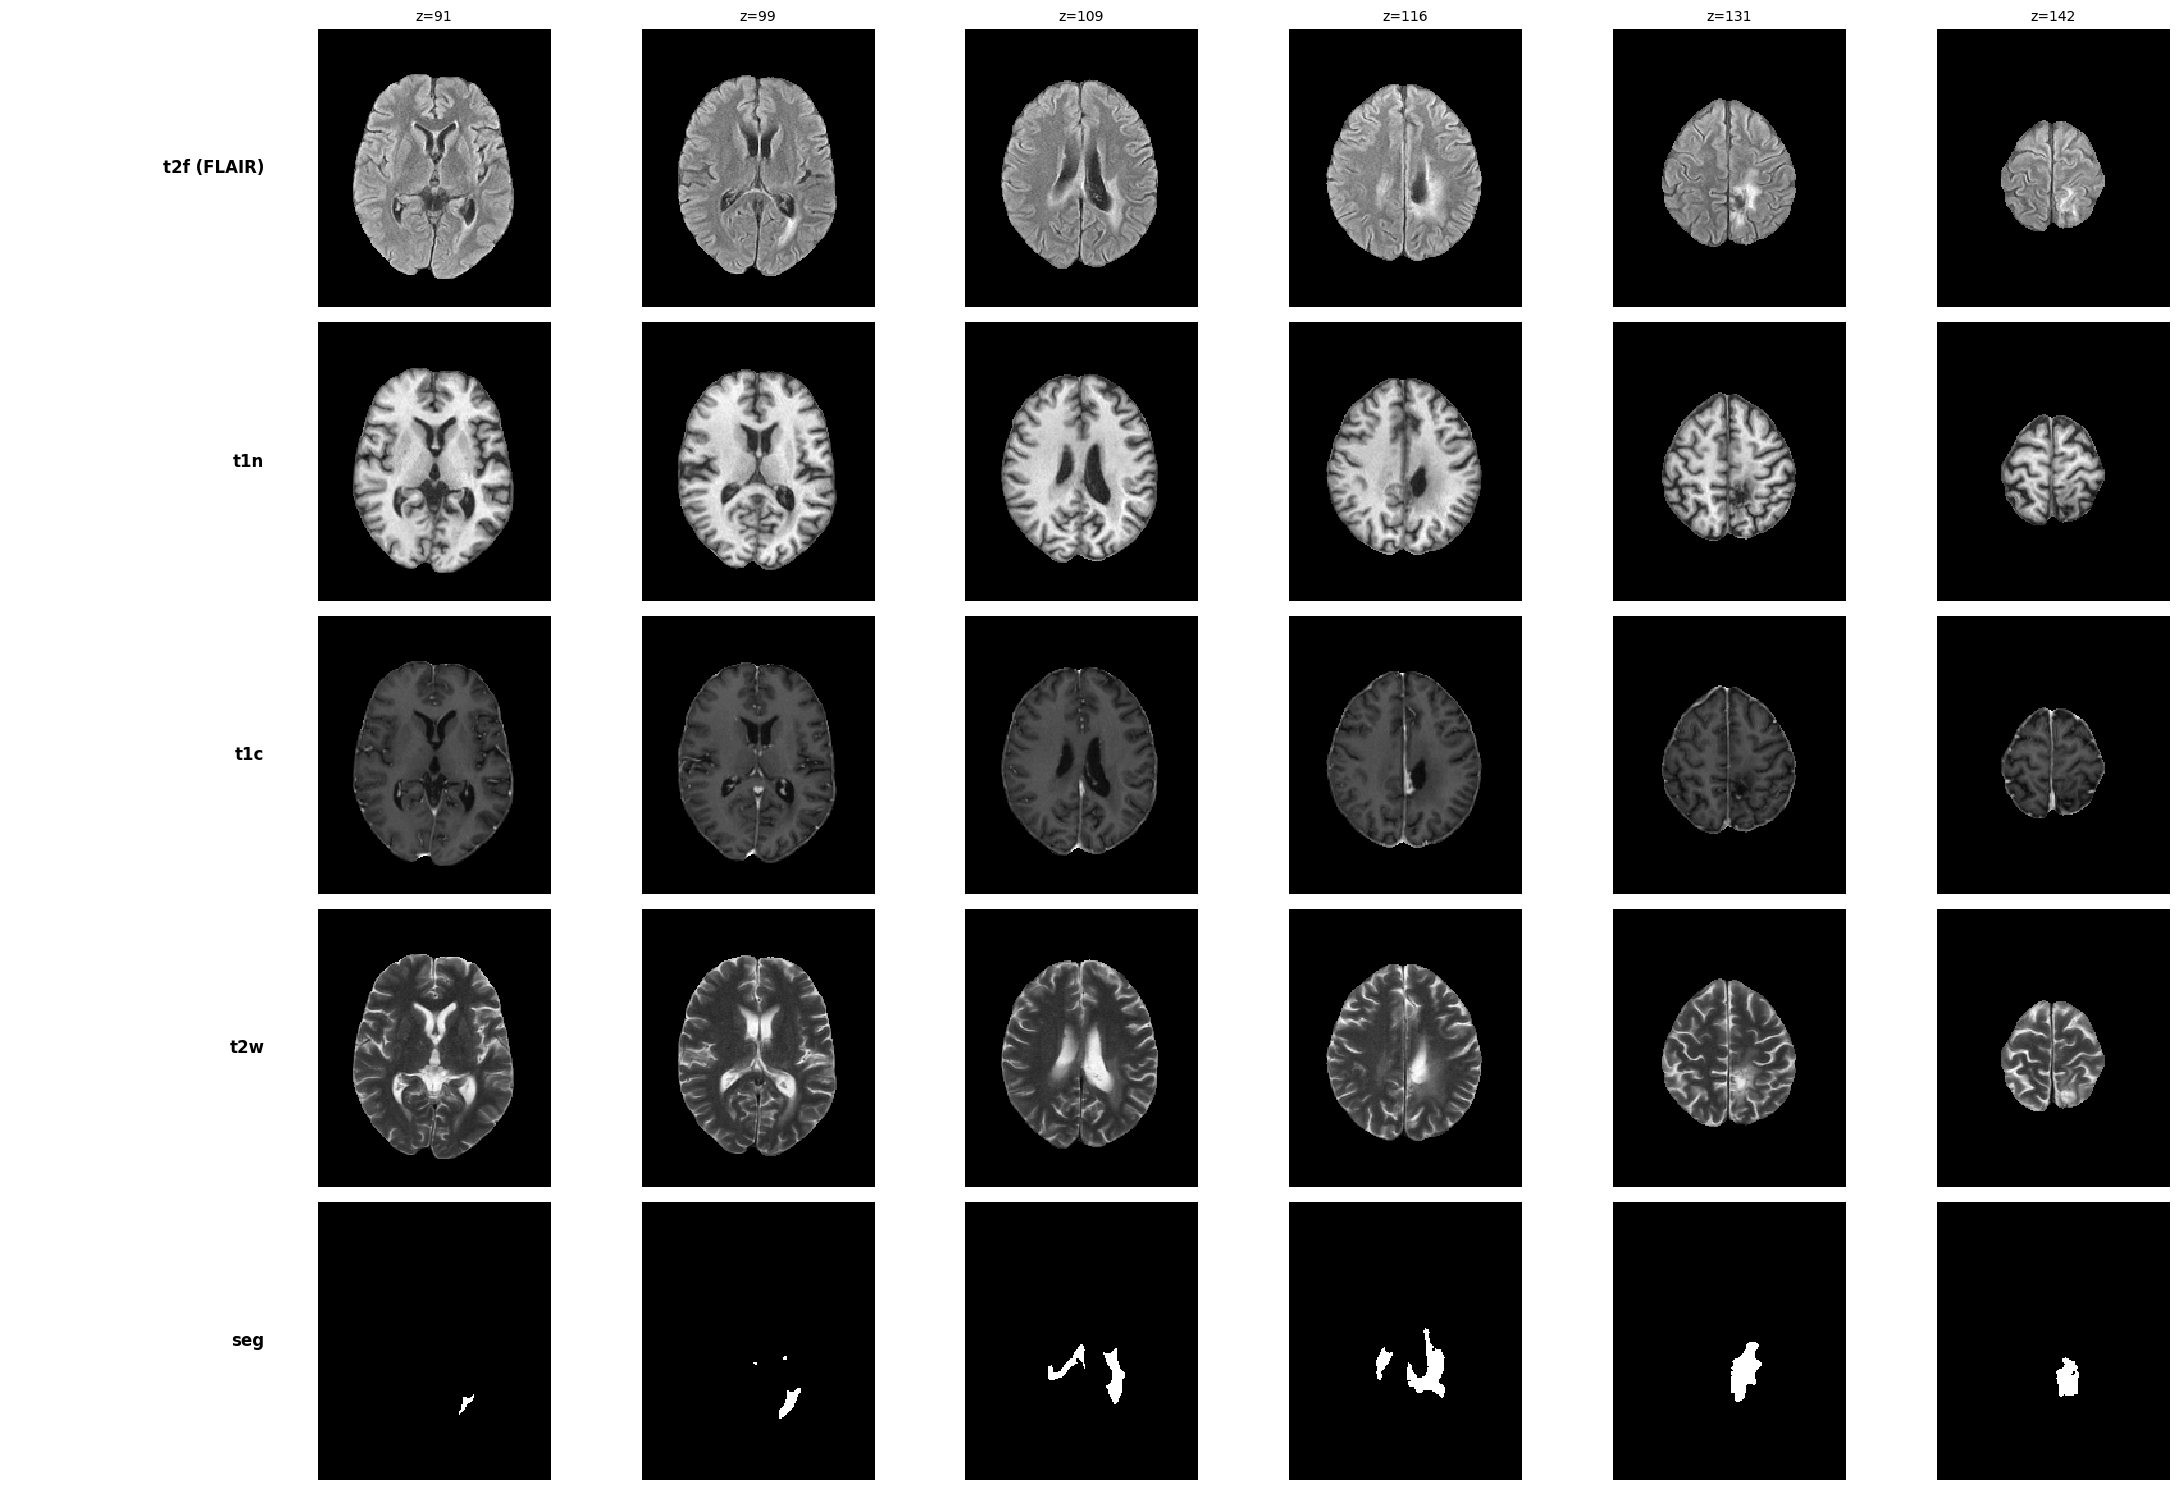

In [15]:
META_2024_CSV   = os.path.join(SUBDATASET_2024, "metadata_2024.csv")
SEQ_2024        = ["t2f","t1n","t1c","t2w","seg"]
SEQ_LABELS_2024 = ["t2f (FLAIR)", "t1n", "t1c", "t2w", "seg"]

# 1) Carrega metadata e faz contagem por sequência + total
meta2024 = pd.read_csv(META_2024_CSV)
counts_2024 = {seq: int(meta2024[seq].notna().sum()) for seq in SEQ_2024}
counts_2024["total_imagens"] = sum(counts_2024[s] for s in SEQ_2024)
df_count_2024 = pd.DataFrame([{ "ano": 2024, **counts_2024 }])
display(df_count_2024)

# 2) Seleciona paciente já escolhido no DataLoader (fallback para primeiro do CSV)
pid24 = os.path.basename(patient_folder_24) if "patient_folder_24" in globals() else meta2024["paciente"].iloc[0]
rows24 = meta2024.loc[meta2024["paciente"] == pid24].sort_values(["idx_local","z"]).reset_index(drop=True)
assert len(rows24) > 0, f"Nenhuma linha no metadata para paciente {pid24}"

# 3) Carrega slices (.npy)
def load_npy_2024(rel_path):
    return np.load(os.path.join(SUBDATASET_2024, rel_path))

seq2slices_24 = {k: [] for k in SEQ_2024}
sel_z_24 = []
for _, r in rows24.iterrows():
    for seq in SEQ_2024:
        seq2slices_24[seq].append(load_npy_2024(r[seq]))
    sel_z_24.append(int(r["z"]))

# garante no máximo 6 colunas
for k in SEQ_2024:
    seq2slices_24[k] = seq2slices_24[k][:6]
sel_z_24 = sel_z_24[:6]

# 4) Plot — usa np.rot90 para girar
ncols = len(sel_z_24)
fig, axes = plt.subplots(len(SEQ_2024), ncols+1,
                         figsize=(3.2*(ncols+1), 3.0*len(SEQ_2024)),
                         gridspec_kw={"width_ratios":[0.8]+[1]*ncols})

for r, (seq, label) in enumerate(zip(SEQ_2024, SEQ_LABELS_2024)):
    # Coluna de rótulo
    ax_label = axes[r,0] if len(SEQ_2024)>1 else axes[0]
    ax_label.axis("off")
    ax_label.text(0.95, 0.5, label, ha="right", va="center", fontsize=12, weight="bold")

    # Slices
    for c, z in enumerate(sel_z_24, start=1):
        ax = axes[r,c] if len(SEQ_2024)>1 else axes[c]
        img = np.rot90(seq2slices_24[seq][c-1])  # rotação
        ax.imshow(img, cmap="gray", interpolation="nearest")
        ax.axis("off")
        if r == 0:
            ax.set_title(f"z={z}", fontsize=10)

plt.tight_layout()
plt.show()

In [23]:
#BLOCO PARA COMMITAR NO MEU REPOSITORIO

#!git init
!git add .
!git commit -m "Dataset Viz"
!git branch -M main
!git remote add origin https://github.com/Henrique-zan/Brain_tumor_segmentation.git
!git push -u origin main

[main 31af333] Dataset Viz
 1 file changed, 14 insertions(+), 16 deletions(-)


error: remote origin already exists.


branch 'main' set up to track 'origin/main'.


To https://github.com/Henrique-zan/Brain_tumor_segmentation.git
   5826308..31af333  main -> main
